In [1]:
import numpy as np
from scipy.linalg import fractional_matrix_power
import matplotlib.pyplot as plt
from itertools import product
from scipy.special import erf

In [2]:
def gaussian_norm(alpha):
    """Normalization constant"""
    return (2 * alpha / np.pi) ** (3/4)

def overlap_element(alpha, beta, A, B):
    """Overlap Integral S"""
    p = alpha + beta
    diff2 = np.dot(A - B, A - B)
    return (np.pi / p)**(3/2) * np.exp(-alpha * beta / p * diff2)

def kinetic_element(alpha, beta, A, B):
    """Kinetic Energy T"""
    p = alpha + beta
    diff2 = np.dot(A - B, A - B)
    gamma = alpha * beta / p
    return gamma * (3 - 2 * gamma * diff2) * (np.pi / p)**(3/2) * np.exp(-gamma * diff2)

def nuclear_attraction_element(alpha, beta, A, B, C, Zc):
    """Electron-Nuclear V"""
    p = alpha + beta
    P = (alpha * A + beta * B) / p
    diff2_AB = np.dot(A - B, A - B)
    diff2_PC = np.dot(P - C, P - C)
    boys0 = boys_function(p * diff2_PC)
    return -Zc * 2 * np.pi / p * np.exp(-alpha * beta / p * diff2_AB) * boys0

def boys_function(x):
    """F_0(x)"""
    if x < 1e-10:
        return 1.0 
    else:
        return 0.5 * (np.pi / x)**0.5 * erf(x**0.5)

def build_one_electron_integrals(basis, atoms):
    """
    basis: [(alpha, A), ...]  # alpha: coefficient, A: coordinate
    atoms: [(Z, C), ...]  # Z: atomic number, C: coordinate
    Return: S, T, V Matrices
    """
    nbf = len(basis)  # Number of basis functions

    S = np.zeros((nbf, nbf))
    T = np.zeros((nbf, nbf))
    V = np.zeros((nbf, nbf))

    for i in range(nbf):
        alpha_i, A = basis[i]
        Ni = gaussian_norm(alpha_i)
        for j in range(i+1):
            alpha_j, B = basis[j]
            Nj = gaussian_norm(alpha_j)

            # Normalization constants
            Sij = Ni * Nj * overlap_element(alpha_i, alpha_j, A, B)
            Tij = Ni * Nj * kinetic_element(alpha_i, alpha_j, A, B)

            Vij = 0.0
            for Zc, C in atoms:
                Vij += Ni * Nj * nuclear_attraction_element(alpha_i, alpha_j, A, B, C, Zc)

            S[i,j] = S[j,i] = Sij
            
            T[i,j] = T[j,i] = Tij
            
            V[i,j] = V[j,i] = Vij
           

    return S, T, V

In [3]:
def eint(a,b,c,d): # Return compound index given four indices using Yoshimine sort
    if a > b: ab = a*(a+1)/2 + b
    else: ab = b*(b+1)/2 + a
    if c > d: cd = c*(c+1)/2 + d
    else: cd = d*(d+1)/2 + c
    if ab > cd: abcd = ab*(ab+1)/2 + cd
    else: abcd = cd*(cd+1)/2 + ab

    return abcd

In [4]:
def tei(a, b, c, d): # Return value of two electron integral
    return twoe.get(eint(a, b, c, d), 0) 

In [5]:
def fprime(X, F): # Put Fock matrix in orthonormal AO basis
    return np.dot(np.transpose(X), np.dot(F, X)) 

In [6]:
def makedensity(C, D, dim, Nelec): # Make density matrix and store old one to test for convergence
    Dold = np.zeros((dim, dim))
    for mu in range(0, dim):
        for nu in range(0, dim):
            Dold[mu,nu] = D[mu, nu]
            D[mu,nu] = 0
            for m in range(0, int(Nelec/2)):
                D[mu,nu] = D[mu,nu] + 2*C[mu,m]*C[nu,m]

    return D, Dold 

In [7]:
def makefock(Hcore, P, dim):
    """Make Fock Matrix using tensor operations."""
    F = Hcore.copy()
    tei_tensor = np.zeros((dim, dim, dim, dim))

    # Build the two-electron integral tensor
    for i, j, k, l in product(range(dim), repeat=4):
        tei_tensor[i, j, k, l] = tei(i, j, k, l)

    # Compute the Fock matrix using tensor operations
    F += np.einsum('kl,ijkl->ij', P, tei_tensor) - 0.5 * np.einsum('kl,ilkj->ij', P, tei_tensor)

    return F

In [8]:

def deltap(D, Dold): # Calculate change in density matrix using Root Mean Square Deviation (RMSD)
    DELTA = 0.0
    for i in range(0, dim):
        for j in range(0, dim):
            DELTA = DELTA + ((D[i,j] - Dold[i,j])**2)

    return (DELTA)**(0.5)

In [9]:
def currentenergy(D, Hcore, F, dim): # Calculate energy at iteration
    EN = 0
    for mu in range(0, dim):
        for nu in range(0, dim):
            EN += 0.5*D[mu,nu]*(Hcore[mu,nu] + F[mu,nu])
            
    return EN

In [10]:
def nucnucenergy(atoms):
    """Calculate nuclear-nuclear repulsion energy"""
    EN = 0
    for i in range(len(atoms)):
        for j in range(i+1, len(atoms)):
            Z1, A1 = atoms[i]
            Z2, A2 = atoms[j]
            r = np.linalg.norm(A1 - A2)
            EN += Z1 * Z2 / r
    return EN

In [11]:

def electron_repulsion_integral(alpha_i, A, alpha_j, B, alpha_k, C, alpha_l, D):
    """Compute the (ij|kl) electron repulsion integral."""
    Ni = gaussian_norm(alpha_i)
    Nj = gaussian_norm(alpha_j)
    Nk = gaussian_norm(alpha_k)
    Nl = gaussian_norm(alpha_l)
    p = alpha_i + alpha_j
    q = alpha_k + alpha_l
    P = (alpha_i * A + alpha_j * B) / p
    Q = (alpha_k * C + alpha_l * D) / q
    RPQ2 = np.dot(P - Q, P - Q)
    value = (2 * np.pi ** 2.5) / (p * q * np.sqrt(p + q)) \
            * np.exp(-alpha_i * alpha_j * np.dot(A - B, A - B) / p) \
            * np.exp(-alpha_k * alpha_l * np.dot(C - D, C - D) / q) \
            * boys_function(p * q * RPQ2 / (p + q))
    return Ni * Nj * Nk * Nl * value

def build_twoe_dict(basis):
    """Build the two-electron integral dictionary."""
    twoe = {}
    nbf = len(basis)
    for i, j, k, l in product(range(nbf), repeat=4):
        val = electron_repulsion_integral(basis[i][0], basis[i][1], basis[j][0], basis[j][1],
                                          basis[k][0], basis[k][1], basis[l][0], basis[l][1])
        twoe[eint(i,j,k,l)] = val
    return twoe

In [12]:
dim =2
charge = 1 
basis = [
    (0.4166, np.array([0.0, 0.0, 0])),  # H：alpha=0.4166，origin
    (0.7739, np.array([0.0, 0.0, 1.5117]))   # He：alpha=0.7739，R=1.5117
]

atoms = [
    (1, np.array([0.0, 0.0, 0])),  # charge for H core and coordinate 
    (2, np.array([0.0, 0.0,  1.5117]))   # He
]

total_nuclear_charge = sum(atom[0] for atom in atoms)
Nelec = total_nuclear_charge - charge

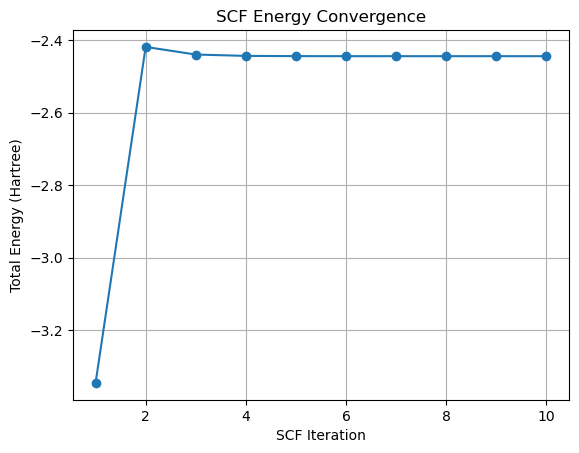

SCF procedure complete, TOTAL E(SCF) = -2.444234522670737 hartrees


In [13]:

S, T, V = build_one_electron_integrals(basis, atoms)

Hcore = T + V

Enuc = nucnucenergy(atoms) # 核间能量

S_minhalf= fractional_matrix_power(S,-0.5)


P   = np.zeros((dim, dim))

twoe = build_twoe_dict(basis)


DELTA        = 1 
count        = 0 
energy_list  = []  

while DELTA > 0.000001:
    count     += 1
    F         = makefock(Hcore, P, dim)
    Fprime    = fprime(S_minhalf, F)
    E, Cprime = np.linalg.eigh(Fprime)
    C         = np.dot(S_minhalf, Cprime)
    P, OLDP   = makedensity(C, P, dim, Nelec)
    DELTA     = deltap(P, OLDP)
    
    current_E = currentenergy(P, Hcore, F, dim) + Enuc  # 这次迭代的总能量
    energy_list.append(current_E)                      # 加进能量变化列表
    
plt.figure()
plt.plot(range(1, len(energy_list)+1), energy_list, marker='o')
plt.xlabel('SCF Iteration')
plt.ylabel('Total Energy (Hartree)')
plt.title('SCF Energy Convergence')
plt.grid(True)
plt.show()

print("SCF procedure complete, TOTAL E(SCF) = {} hartrees".format(currentenergy(P, Hcore, F, dim) + Enuc))
